### Objective

This notebook is about applying deep learning models to predict the helpfulness of the amazon review dataset. We have already seem to have applied traditonal model approach to  the problem statement. Based on the traditional approach, using SMOTE Sampling TF-IDF RandomForest Classifier accuracy score was about 73% and precision score as 84%. You can find the details about the traditional approach in the github link: 

https://github.com/subhashree-ai/amazon-review-helpfulness-prediction/blob/master/notebooks/amazon_helpfulness_prediction_trad_models.ipynb


In this notebook, we will apply the deep learning methods on the frequency datasets which we have already saved in the input directory. In case, if you want to reload the data, we have the code written in the notebook, which can be used.

### Import and Initialization 

In [1]:
# Importing the relevant dependencies
import numpy as np
import pandas as pd
import gzip
import math, time, random, datetime
import string
import os
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')

# data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from IPython.display import display # Allows the use of display() for DataFrames
import warnings
warnings.filterwarnings('ignore')
import re
from collections import Counter
import pickle
from sklearn.model_selection import train_test_split

# Deep Learning Keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Embedding, Dropout, Activation,Flatten
from keras.preprocessing.text import Tokenizer
from tensorflow.python.keras import metrics
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\src\\utils")

In [3]:
import utility
from custom_text_preprocessing import normalize_text
from custom_transformer import ColumnExtractor, TextTFIDFVectorizer, TextWord2Vectorizer
from plotting import report, plot_roc, plot_history

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# folder where input data and pickle data load present
data_folder = '../data/dataLoad/'
input_folder = '../data/raw/'

### Data Loading

In [5]:
# Load the pickle for dataset having frequency 0.8, 0,85 and 0.9 if you have already executed the traditional models 
# approach where the threshold dataset for 0.8, 0.85 and 0.9 has already been saved
dataset_threshold_08 = pickle.load((open(input_folder+'dataset_threshold_08.p', 'rb')))
dataset_threshold_085 = pickle.load((open(input_folder+'dataset_threshold_085.p', 'rb')))
dataset_threshold_09 = pickle.load((open(input_folder+'dataset_threshold_09.p', 'rb')))

In [6]:
# In case, if you dont have the dataset for threshold frequency not saved, 
# uncomment the below commented cell and run to get the threshold datasets

# Loading the home and kitchen dataset which is downloaded in the /data path
#input_data = 'reviews_Home_and_Kitchen_5.json.gz'
#def parse(path):
#    g = gzip.open(path, 'rb')
#    for l in g:
#        yield eval(l)

#def getDF(path):
#    i = 0
#    df = {}
#    for d in parse(path):
#        df[i] = d
#        i +=1
#    return pd.DataFrame.from_dict(df, orient='index')

#data = getDF(input_folder + input_data)   

# Data Preprocessing
# Filter the products which has atleast 10 reviews
#groupby_product = data.groupby('asin').size()
#filter_reviews = data.groupby('asin').size().values >= 10
#filter_asins = groupby_product[filter_reviews].index
#data_filter = data.loc[data['asin'].isin(filter_asins), :]

# Filter the reviews having more than 10 helpful reviews
#dataset = data_filter[data_filter['helpful'].apply(lambda x: x[1] > 10)]

#Deriving the target variables from features
#dataset['helpful_ratings'] = dataset['helpful'].apply(lambda x: x[0])
#dataset['total_ratings'] = dataset['helpful'].apply(lambda x: x[1])

# Droping some of the outliers
#dataset = dataset.drop(dataset.index[dataset.helpful_ratings == dataset.helpful_ratings.max()])
#dataset = dataset.drop(dataset.index[dataset.total_ratings > 1000])

# This funcion will get the helpfulness rating based on certain threshold and total and helpful ratings count
#def getHelpfulness(input_dataset, threshold):
#    threshold=threshold
#    input_dataset.loc[:, 'isHelpful'] = np.where(input_dataset['helpful_ratings']/input_dataset['total_ratings'] > threshold, 1, 0)
    
#    return input_dataset

# Dataset with threshold 0.8
#dataset_threshold_08 = getHelpfulness(dataset, threshold=0.8)
#dataset_threshold_08 = dataset.drop(columns = ['helpful', 'helpful_ratings', 'total_ratings'], axis=1)
#dataset_threshold_08 = dataset_threshold_08.reset_index(drop=True)

# Dataset with threshold 0.85
#dataset_threshold_085 = getHelpfulness(dataset, threshold=0.85)
#dataset_threshold_085 = dataset.drop(columns = ['helpful', 'helpful_ratings', 'total_ratings'], axis=1)
#dataset_threshold_085 = dataset_threshold_08.reset_index(drop=True)

# Dataset with threshold 0.9
#dataset_threshold_09 = getHelpfulness(dataset, threshold=0.9)
#dataset_threshold_09 = dataset.drop(columns = ['helpful', 'helpful_ratings', 'total_ratings'], axis=1)
#dataset_threshold_09 = dataset_threshold_08.reset_index(drop=True)

Dataset Description:


As mentioned in the jmcauley site, belaw are the description of the fields:
1. reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
2. asin - ID of the product, e.g. 0000013714
3. reviewerName - name of the reviewer
4. helpful - helpfulness rating of the review, e.g. 2/3.
5. reviewText - text of the review
6. overall - rating of the product
7. summary - summary of the review
8. unixReviewTime - time of the review (unix time)
9. reviewTime - time of the review (raw)

Below are the strategies will foloow for finding the best approach:
1. Will pass the review Text without normalizing the text.
2. Will normalize the review text which involves removing the  punctuation, stemming, lemmitisation process etc.
3. Will pass the normalize review text along with the date parameter which will signify how old the data is.

All these input strategies will be passed to different neural networks like LSTM, RNN and Transfer Learning as word embeddings, and to different threshold dataset

#### Building Neural networks using input as reviewText( without normalizing) 

###### Using dataset threshold 0.8 

In [7]:
# Train-Test split the dataset_threshold_08
X_08 = dataset_threshold_08['reviewText'].values
y_08 = dataset_threshold_08['isHelpful'].values

sentences_train_08, sentences_test_08, y_train_08, y_test_08 = train_test_split(X_08, y_08, test_size=0.33, random_state=42)

###### LSTM Model

In [8]:
embedding_size = 200
num_words = 10000
max_tokens = 30

In [9]:
tokenizer_08 = Tokenizer(num_words=10000)
tokenizer_08.fit_on_texts(sentences_train_08)

X_train_08 = tokenizer_08.texts_to_sequences(sentences_train_08)
X_test_08 = tokenizer_08.texts_to_sequences(sentences_test_08)

vocab_size = len(tokenizer_08.word_index) + 1
print(sentences_train_08[2])
print(X_train_08[2])

I'm torn on this product. Now that I have it completely assembled and put in place, I love it. However, while assembling it I was almost prepared to throw it away.- There are 174 pieces that come with it. Yes, 174. 20 pieces of wood and 154 pieces of hardware. I eventually had my entire kitchen floor covered in pieces.- Many of the wood pieces are not labeled so you end up guessing and hoping it's right.- The directions were very confusing at points. One showed a long and skinny piece. I searched and searched for the piece and got upset because I thought they shorted me some pieces. It turns out that the piece did come with it, but it was actually short and stubby.- Some of the holes did not feel like they were drilled deep enough and I had to push the screws in very hard to make it work.- Took a very long time to assemble. Especially in the days of Ikea's "build anything in 30 minutes" this was very frustrating that they could not have engineered it better.Like I said, it was a huge p

In [10]:
len(tokenizer_08.word_index)

48744

In [11]:
X_train_08 = pad_sequences(X_train_08, padding='post', maxlen=max_tokens)
X_test_08 = pad_sequences(X_test_08, padding='post', maxlen=max_tokens)

print(X_train_08[0, :])

[  26  178  292  692    2   40  460  394  728   27    6 3999   30   66
  174   80    2   45   54  153    6    2   28    6  279  171  217 4452
   11 4415]


In [12]:
from keras.layers import LSTM

model = Sequential()
optimizer = Adam(lr=1e-3)

In [13]:
model.add(Embedding(input_dim=num_words, output_dim=embedding_size, input_length=max_tokens, name='layer_embedding'))
model.add(LSTM(units=16, return_sequences=True))

model.add(LSTM(units=8, return_sequences=True))
model.add(LSTM(units=8, return_sequences=True))
model.add(LSTM(units=4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_embedding (Embedding)  (None, 30, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 16)            13888     
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 8)             800       
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 8)             544       
_________________________________________________________________
lstm_4 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 2,015,445
Trainable params: 2,015,445
Non-trainable params: 0
____________________________________________

In [15]:
%%time
history = model.fit(X_train_08, y_train_08,
                    epochs=5,
                    verbose=False,
                    validation_data=(X_test_08, y_test_08),
                    batch_size=500)

Wall time: 43.7 s


In [16]:
%%time
loss, accuracy = model.evaluate(X_train_08, y_train_08, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.8541
Wall time: 8.98 s


In [17]:
%%time
predicted = model.predict(X_train_08)
predicted = predicted.T[0]
cls_pred = np.array([1.0 if p>0.8 else 0.0 for p in predicted])

Wall time: 7.17 s


Testing Accuracy:  0.8056
              precision    recall  f1-score   support

   isHelpful       0.66      0.69      0.68      3460
  notHelpful       0.93      0.92      0.92     14903

    accuracy                           0.88     18363
   macro avg       0.79      0.80      0.80     18363
weighted avg       0.88      0.88      0.88     18363



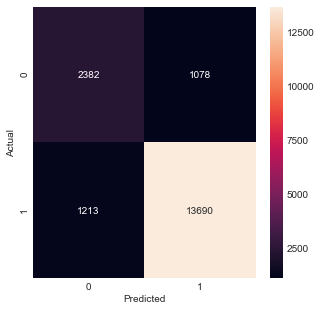

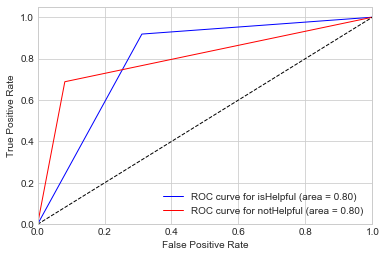

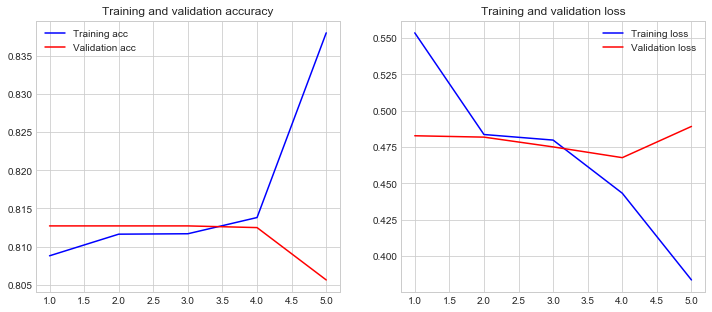

Wall time: 5.74 s


In [18]:
%%time
loss, accuracy = model.evaluate(X_test_08, y_test_08, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
report(y_train_08, cls_pred)
plot_roc(y_train_08, cls_pred)
plot_history(history)

References : 

https://realpython.com/python-keras-text-classification/